In [4]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
#import albumentations as A
#from albumentations.pytorch import ToTensorV2
#import cv2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
import torchvision

In [7]:
# path
# C:\Users\utente\Desktop\projelerim\Image-Recoloring-master\New folder\test_color
import glob

In [8]:
path = r"C:\Users\utente\Desktop\projelerim\Image-Recoloring-master\New folder\test_color"
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 500, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(500)
train_idxs = rand_idxs[:400] # choosing the first 8000 as training set
val_idxs = rand_idxs[400:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

400 100


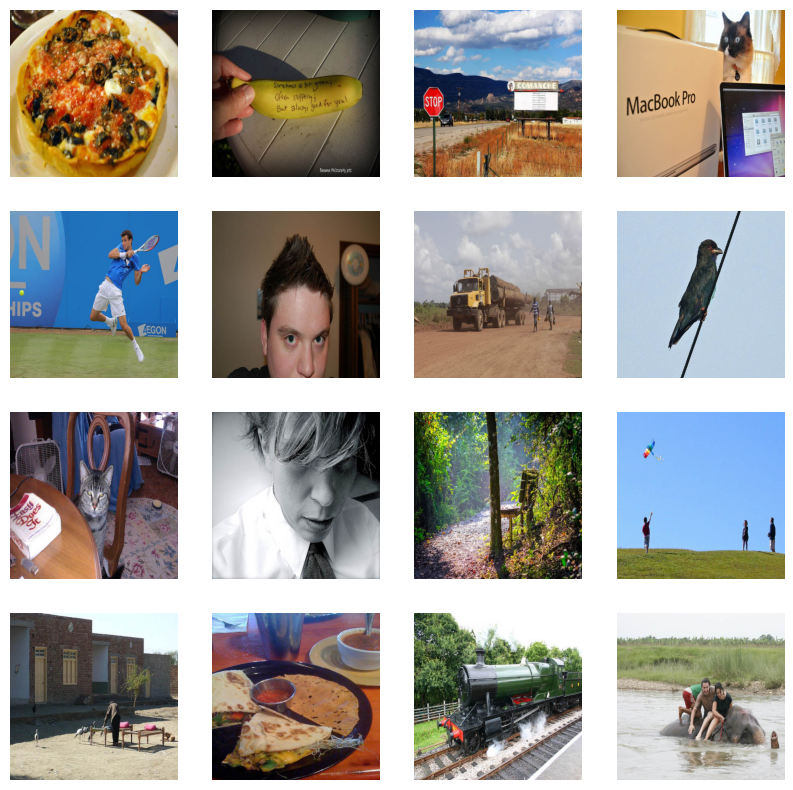

In [11]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [47]:
from skimage import io, color

def im_get(idx):
    img = Image.open(paths[idx]).convert('RGB')
    img = img.resize((224,224))
    lab = color.rgb2lab(img)
    lab = np.array(lab)
    l = lab[:,:,0]
    #a = lab[:,:,1]
    #b = lab[:,:,2]
    ab = lab[:,:,1:]
    return [l,ab]


In [48]:
L_df = []
ab_df = []
for idx in rand_idxs[:10]:
    L_df.append(im_get(idx)[0])
    ab_df.append(im_get(idx)[1])
    
L_df = np.array(L_df)
ab_df = np.array(ab_df)

In [51]:
ab_df[0].min()

-59.09567266500615

In [45]:
img = cv2.imread(paths[1])
LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

cv2.imwrite('L.png', LAB[:,:,0])
cv2.imwrite('a.png', LAB[:,:,1])
cv2.imwrite('b.png', LAB[:,:,2])

BGR = cv2.cvtColor(LAB, cv2.COLOR_LAB2BGR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('new.png', BGR)


True

In [55]:
L_df.shape

(10, 224, 224)

In [56]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)

In [58]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        x = torch.cat([x,y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [60]:
def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    preds = model(x, y)
    print(preds.shape)
test()

torch.Size([1, 1, 30, 30])


In [61]:
class Block(nn.Module): 
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [62]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        ) # 128
        
        self.down1 = Block(features, features*2, down=True, act="leaky", use_dropout=False) # 64
        self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False) # 32
        self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False) # 16
        self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 8
        self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 4
        self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) # 2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode="reflect"), 
            nn.ReLU() # 1x1
        )
        self.up1 = Block(features*8, features*8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [64]:
def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 3, 256, 256])


In [65]:
def save_checkpoint(model, optimizer, filename):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    
def save_some_examples(gen, test_loader, epoch):
    x, y = next(iter(test_loader))
    x, y = x.to(DEVICE).squeeze(1), y.to(DEVICE).squeeze(1)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5 # remove normalization
        torchvision.utils.save_image(y_fake, f"/y_gen_{epoch}.png")
        torchvision.utils.save_image(x * 0.5 + 0.5, f"/input_{epoch}.png")
        if epoch == 1:
            torchvision.utils.save_image(y, f"/label_{epoch}.jpg")
    gen.train()

In [66]:
def train_fn(disc, gen, train_loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
    loop = tqdm(train_loader, leave=True)
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE).squeeze(1), y.to(DEVICE).squeeze(1)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x, y)
            d_fake = disc(x, y_fake.detach())
            d_real_loss = bce(d_real, torch.ones_like(d_real))
            d_fake_loss = bce(d_fake, torch.zeros_like(d_fake))
            d_loss = (d_real_loss + d_fake_loss) / 2
        
        disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # Train Generator
        with torch.cuda.amp.autocast():
            d_fake = disc(x, y_fake)
            g_fake_loss = bce(d_fake, torch.ones_like(d_fake))
            L1 = l1(y_fake, y) * L1_LAMBDA
            g_loss = g_fake_loss + L1
        
        gen.zero_grad()
        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

In [67]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()
    
    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
    
    train_data = ImageDataset(TRAIN_BLACK_DIR, TRAIN_COLOR_DIR, augmentations)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_data = ImageDataset(TEST_BLACK_DIR, TEST_COLOR_DIR, augmentations)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        print("Epoch: ", epoch)
        train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
        
        if SAVE_MODEL and epoch % 2 == 0:
            save_checkpoint(gen, opt_gen, "checkpoint_gen.pth.tar")
            save_checkpoint(disc, opt_disc, "checkpoint_disc.pth.tar")
            
        save_some_examples(gen, test_loader, epoch)

In [69]:
(23/30)*4

3.066666666666667